### ERP exercise raport

In [7]:
#| title: import libraries
#| include: false
from pathlib import Path
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import scipy.stats

In [8]:
#| title: download data
#| include: false
data_dir = Path(mne.datasets.erp_core.data_path('.'))
file_name = data_dir / "ERP-CORE_Subject-001_Task-Flankers_eeg.fif"


100%|#####################################| 92.0M/92.0M [00:00<00:00, 92.2GB/s]
Untarring contents of 'C:\Users\agata\Documents\MLN\MNE-ERP-CORE-data.tar.gz' to 'C:\Users\agata\Documents\MLN\.'


Attempting to create new mne-python configuration file:
C:\Users\agata\.mne\mne-python.json
Download complete in 11s (87.8 MB)


In [9]:
#| title: read raw file
#| include: false
raw = mne.io.read_raw(file_name, preload=True)
raw_filtered = raw.copy().filter(l_freq=0.1, h_freq=30)

Opening raw data file MNE-ERP-CORE-data\ERP-CORE_Subject-001_Task-Flankers_eeg.fif...
    Range : 0 ... 935935 =      0.000 ...   913.999 secs
Ready.
Reading 0 ... 935935  =      0.000 ...   913.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (33.001 s)



In [10]:
#| title: create ERP epochs
#| include: false
tmin=-0.2
tmax=0.8

events, _ = mne.events_from_annotations(raw_filtered)
congruent_event_ids = {
    'stimulus/compatible/target_left': 3,
    'stimulus/compatible/target_right': 4,
}
incongruent_event_ids = {
      'stimulus/incompatible/target_left': 5,
      'stimulus/incompatible/target_right': 6
}

congruent_epochs = mne.Epochs(
  raw=raw_filtered,
  events=events,
  event_id=congruent_event_ids,
  tmin=tmin,
  tmax=tmax,
  baseline=(-0.2, 0),
  preload=True,
)

incongruent_epochs = mne.Epochs(
  raw=raw_filtered,
  events=events,
  event_id=incongruent_event_ids,
  tmin=tmin,
  tmax=tmax,
  baseline=(-0.2, 0),
  preload=True,
)

Used Annotations descriptions: ['response/left', 'response/right', 'stimulus/compatible/target_left', 'stimulus/compatible/target_right', 'stimulus/incompatible/target_left', 'stimulus/incompatible/target_right']
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 1025 original time points ...
0 bad epochs dropped
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 1025 original time points ...
0 bad epochs dropped


To decide on a time frame I’ve looked at evokeds on the Cz electrode to see where the signal is changing the most after the stimuli. For this exercise I’ve picked **tmin=01** and **tmax=0.6**

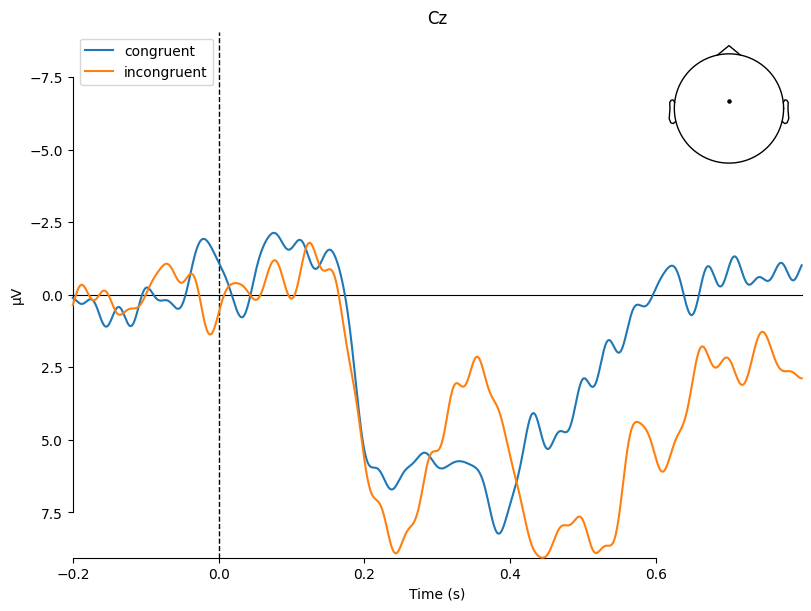

In [16]:
#| title: plot evoked
#|echo: false
evokeds = dict(
    congruent=congruent_epochs.average(),
    incongruent=incongruent_epochs.average()
)
picks = ['Cz']
fig = mne.viz.plot_compare_evokeds(
    evokeds = evokeds,
    picks=picks,
    invert_y=True
)

In [12]:
#| title: get electrodes name
#| include: false
electrodes = raw.info.ch_names[:-3]

In [13]:
#| title: loop over electrodes, get p-values
#| include: false
results = []
for electrode in electrodes:
  congruent_mean = congruent_epochs.get_data(picks=[electrode], tmin=0.1, tmax=0.6)
  congruent_mean = np.mean(congruent_mean, axis=-1)
  incongruent_mean = incongruent_epochs.get_data(picks=[electrode], tmin=0.1, tmax=0.6)
  incongruent_mean = np.mean(incongruent_mean, axis=-1)
  t_test = scipy.stats.ttest_rel(congruent_mean, incongruent_mean)
  results_dict ={
      "Electrode" : electrode,
      "T-test stats" : t_test.statistic[0],
      "P-value" : t_test.pvalue[0]
  }
  results.append(results_dict)


Instead of picking a one electrode to focus on I decided on a more exploratory approach – looping over all the electrodes to find out which one had the most statistical relevance in the already decided time window. Lowest p-values are prevalent mostly in the frontal and central area with **F8, FC3, Cz, FC4 and F3** where p<0.05.

In [14]:
#| title: show results
#| include: true
#| echo: false
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="P-value"))

   Electrode  T-test stats   P-value
18        F8     -2.195738  0.029267
3        FC3     -2.188451  0.029801
21        Cz     -2.134581  0.034019
19       FC4     -2.082334  0.038591
1         F3     -1.974201  0.049742
17        F4     -1.802780  0.072936
20       FCz     -1.697455  0.091174
14       CPz     -1.655490  0.099401
13        Pz     -1.654942  0.099513
29        O2     -1.570554  0.117875
4         C3     -1.531279  0.127289
16        Fz     -1.399865  0.163111
0        FP1     -1.354407  0.177142
24        P4     -1.323683  0.187127
28       PO4     -1.322301  0.187586
11        O1     -1.280497  0.201861
6         P3     -1.210472  0.227534
10       PO3     -0.981081  0.327744
15       FP2     -0.954348  0.341066
26       P10     -0.818007  0.414331
8         P9      0.818005  0.414333
2         F7     -0.780686  0.435915
23        C6     -0.687364  0.492654
22        C4     -0.637096  0.524795
12        Oz     -0.599151  0.549754
5         C5     -0.589069  0.556483
9